In [211]:
import numpy as np
import matplotlib.pyplot as plt

In [212]:
# All possible cards
cards = ["2", "3", "4", "5", "6", "7", "8", "9", "10", "A"]

In [213]:
useable_ace = True

In [214]:
# List of all states
states = []
for i in range(4, 22):
    for j in range(2, 12) if useable_ace else range(1, 11):
        for k in [useable_ace,]:
            states.append((i, j, k))

In [215]:
class Environment():
    def __init__(self,):
        # Environment cards
        self.cards = cards
        self.probs = [1.0/len(self.cards) for i in range(0, len(self.cards))]
        
        # Reset the environment to start the environment
        self.reset_environment()
    
    # Used to make an action in the current state. Return the reward for the action.
    def take_action(self, action):
        if action == "HIT":
            self.player.append(np.random.choice(self.cards, size=1, replace=True, p=self.probs)[0])
        elif action == "STAY":
            self.user_end = True
        else:
            raise RuntimeError(f"Unknown action {action}")
        
        # Reward is 0 for every game.
        return 0
        
    # Used to get all the actions
    def get_actions(self,):
        return self.cards
    
    # Used to get the sum of a list of items
    def get_sum(self, items):
        s = 0
        for i in items:
            if i in ["2", "3", "4", "5", "6", "7", "8", "9", "10"]:
                s += int(i)
            elif i == "A":
                s += 11 if self.useable_ace else 1
            else:
                raise RuntimeError(f"Unknown card: {i}")
        return s
    
    # Used to get the current state
    def get_state(self, ):
        # State is the current user sum, the dealer's showing card, and if the ace is useable or not.
        return self.get_sum(self.player), self.get_sum(self.dealer[:1]), self.useable_ace
    
    # Has the game ended?
    def game_ended(self, ):
        # Game has ended if the player busts or if the player has stopped the game
        if self.user_end or self.get_sum(self.player) > 21:
            return True
        return False
    
    # Used to end an episode and reset the environment, returning the reward
    # at the end of the game.
    def end_episode(self, ):
        # Did the user bust, if so, return -1
        if self.get_sum(self.player) > 21:
            self.reset_environment()
            return -1
        
        # Iterate until the dealer is 17 or over
        while self.get_sum(self.dealer) < 17:
            self.dealer.append(np.random.choice(self.cards, size=1, replace=True, p=self.probs)[0])
            
        # Did the dealer bust, if so, return 1
        if self.get_sum(self.dealer) > 21:
            self.reset_environment()
            return 1
        
        # If the dealer has a higher value, return -1
        if self.get_sum(self.dealer) > self.get_sum(self.player):
            self.reset_environment()
            return -1
        
        # If the player has a higher value, return 1
        elif self.get_sum(self.dealer) < self.get_sum(self.player):
            self.reset_environment()
            return 1
        
        # If not, then it's a tie
        self.reset_environment()
        return 0
    
    # Used to reset the environment and start a new episode
    def reset_environment(self, ):
        # Sample two cards for the dealer, first is observable, second is not
        self.dealer = list(np.random.choice(self.cards, size=2, replace=True, p=self.probs))
        
        # Sample two cards for the player
        self.player = list(np.random.choice(self.cards, size=2, replace=True, p=self.probs))
        
        # Reset the usable ace
        self.useable_ace = useable_ace
        
        # Has the user ended the game yet?
        self.user_end = False

In [92]:
# Policy
class Policy():
    def __init__(self, ):
        # Policy is a dictionary of states to actions, actions are either "HIT" or "STAY
        self.policy = {
            state: np.random.choice(["HIT", "STAY"]) for state in states
        }
    
    def __call__(self, state):
        if state not in self.policy:
            self.policy[state] = np.random.choice(["HIT", "STAY"])
        return self.policy[state]

In [93]:
class MonteCarloExploringStates():
    def __init__(self, ):
        # Values for all states that have been seen
        self.values = {
            (state, action): -100 for state in states for action in ["HIT", "STAY"]
        }
        
        # Returns for each state
        self.returns = {
            (state, action): [] for state in states for action in ["HIT", "STAY"]
        }
      
      
        
    # Generate an episode of data given a policy
    def generate_episode(self, policy, game):
        # Episode consists of states, actions, and rewards (indexed at +1)
        episode = {
            "states": [],
            "actions": [],
            "rewards": [0],
        }
        
        # Used to do a random action on the first move
        first_move = True
        
        # Iterate until the game has ended
        while not game.game_ended():
            # Get the state of the game
            state = game.get_state()
            episode["states"].append(state)
            
            # Get a new prediction from the policy
            if first_move:
                action = np.random.choice(["HIT", "STAY"])
                first_move = False
            else:
                action = policy(state)
            episode["actions"].append(action)
            
            # Update the state, get the reward if any
            reward = game.take_action(action)
            episode["rewards"].append(reward)
            
        # End the episode
        episode_reward = game.end_episode()
            
        # Replace last reward with the episode end reward
        episode["rewards"][-1] = episode_reward
        
        return episode
      
        
    # Used to optimize a policy given MC
    def optimize_policy(self, policy, game, num_iters):
        for iter in range(0, num_iters):
            # Generate an episode of data following the policy, pi
            episode = self.generate_episode(policy, game)
            
            # States already visited
            visited = set()
            
            # Generate the reward for the episode
            G = 0
            for t in range(len(episode["states"])-1, -1, -1):
                state = episode["states"][t]
                action = episode["actions"][t]
                reward = episode["rewards"][t+1]
                
                # Update G to the current timestep
                G = discount * G + reward
                
                # Do not revisit already visited states
                if state not in visited:
                    # Save the return, G, for the current state
                    try:
                        self.returns[(state, action)].append(G)
                    except KeyError:
                        self.returns[(state, action)] = [G]
                        
                    # Update the value of this state as teh averge return
                    self.values[(state, action)] = sum(self.returns[(state, action)])/len(self.returns[(state, action)])
                    
                    # Update the policy to be greedy
                    # What is the value of taking the action "HIT"?
                    try:
                        hit_value = self.values[(state, "HIT")]
                    except KeyError:
                        hit_value = -100
                    # What is the value of taking the action "STAY"?
                    try:
                        stay_value = self.values[(state, "STAY")]
                    except KeyError:
                        stay_value = -100
                    # Pick whichever is higher
                    if hit_value > stay_value:
                        policy.policy[state] = "HIT"
                    else:
                        policy.policy[state] = "STAY"
                
                # Update the visited states
                visited.add(state)
                
        return policy

In [94]:
discount = 1.0

In [216]:
# Create environment
env = Environment()

# Create policy
policy = Policy()

# Calculate values by first-visit MC
MCES = MonteCarloExploringStates()

TypeError: Policy.__init__() missing 1 required positional argument: 'num_iters'

In [96]:
policy = MCES.optimize_policy(policy, env, 100_000)

In [97]:
policy.policy

{(4, 2, True): 'HIT',
 (4, 3, True): 'HIT',
 (4, 4, True): 'HIT',
 (4, 5, True): 'HIT',
 (4, 6, True): 'HIT',
 (4, 7, True): 'HIT',
 (4, 8, True): 'HIT',
 (4, 9, True): 'HIT',
 (4, 10, True): 'HIT',
 (5, 2, True): 'HIT',
 (5, 3, True): 'HIT',
 (5, 4, True): 'HIT',
 (5, 5, True): 'HIT',
 (5, 6, True): 'HIT',
 (5, 7, True): 'HIT',
 (5, 8, True): 'HIT',
 (5, 9, True): 'HIT',
 (5, 10, True): 'HIT',
 (6, 2, True): 'HIT',
 (6, 3, True): 'HIT',
 (6, 4, True): 'HIT',
 (6, 5, True): 'HIT',
 (6, 6, True): 'HIT',
 (6, 7, True): 'HIT',
 (6, 8, True): 'HIT',
 (6, 9, True): 'HIT',
 (6, 10, True): 'HIT',
 (7, 2, True): 'HIT',
 (7, 3, True): 'HIT',
 (7, 4, True): 'HIT',
 (7, 5, True): 'HIT',
 (7, 6, True): 'HIT',
 (7, 7, True): 'HIT',
 (7, 8, True): 'HIT',
 (7, 9, True): 'HIT',
 (7, 10, True): 'HIT',
 (8, 2, True): 'HIT',
 (8, 3, True): 'HIT',
 (8, 4, True): 'HIT',
 (8, 5, True): 'HIT',
 (8, 6, True): 'HIT',
 (8, 7, True): 'HIT',
 (8, 8, True): 'HIT',
 (8, 9, True): 'HIT',
 (8, 10, True): 'HIT',
 (9, 

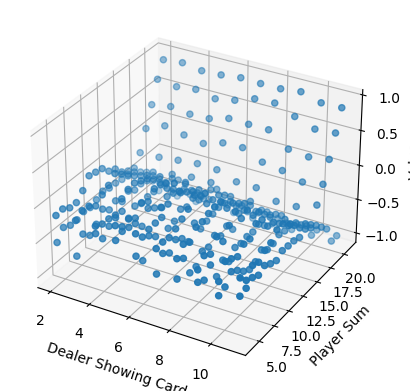

In [98]:
# Plot a 3D plot where the x-axis is the dealer showing card, the y-axis is the player sum, and the z-axis is the value
x = []
y = []
z = []
for state in MCES.values:
    x.append(state[0][1])
    y.append(state[0][0])
    z.append(MCES.values[state])
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
ax.set_xlabel("Dealer Showing Card")
ax.set_ylabel("Player Sum")
ax.set_zlabel("Value")
plt.show()

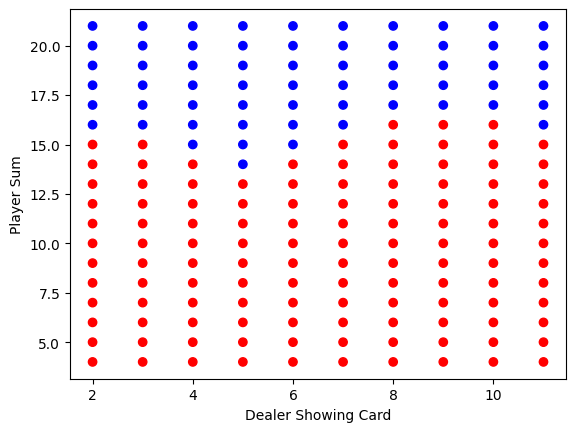

In [99]:
# 2D policy plot with the x-axis as the dealer showing card, the y-axis as the player sum, and the color as the action
x = []
y = []
z = []
for state in policy.policy:
    x.append(state[1])
    y.append(state[0])
    z.append("red" if policy.policy[state] == "HIT" else "blue")

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y, c=z)
ax.set_xlabel("Dealer Showing Card")
ax.set_ylabel("Player Sum")
plt.show()

In [248]:
# Stochasic epsilon-greedy Policy
class Policy():
    def __init__(self, num_iters):
        # Policy is a dictionary of states to actions, actions are either "HIT" or "STAY
        self.policy = {
            state: np.random.choice(["HIT", "STAY"]) for state in states
        }
        
        # High and low epsilon values
        self.high = 0.2
        self.low = 1e-4
        
        # Define a linspace from 0.2 to 1e-4 for each iteration
        self.epsilons = np.linspace(self.high, self.low, num=num_iters+1)
        
        # Current iteration
        self.cur_iter = 0
    
    def __call__(self, state, behavior_policy=False):
        # Get optimal action
        optimal = self.policy[state]
        
        # If the policy is the target policy, return the optimal action
        if not behavior_policy:
            return optimal
        
        
        # Get nonoptimal action
        nonoptimal = "HIT" if optimal == "STAY" else "STAY"
        
        # Get "random" action
        p = np.random.random(1)[0]
        if p < self.epsilons[self.cur_iter]:
            return nonoptimal, self.epsilons[self.cur_iter]
        return optimal, 1-self.epsilons[self.cur_iter]
    
    def update_iter(self, iter):
        self.cur_iter = iter

In [249]:
# Off policy MC
class OffPolicyMonteCarlo():
    def __init__(self, ):
        # Values for all states that have been seen
        self.values = {
            (state, action): -100 for state in states for action in ["HIT", "STAY"]
        }
        
        # Cumulative weight for each state, action - used to map from off-policy probs
        # to on-policy probs.
        self.cumulative_weights = {
            (state, action): 0 for state in states for action in ["HIT", "STAY"]
        }
      
      
        
    # Generate an episode of data given a policy
    def generate_episode(self, policy, game):
        # Episode consists of states, actions, and rewards (indexed at +1)
        episode = {
            "states": [],
            "actions": [],
            "rewards": [0],
        }
        
        # Iterate until the game has ended
        while not game.game_ended():
            # Get the state of the game
            state = game.get_state()
            episode["states"].append(state)
            
            # Get a new prediction from the policy
            action = policy.__call__(state, behavior_policy=True)
            episode["actions"].append(action)
            
            # Update the state, get the reward if any
            reward = game.take_action(action[0])
            episode["rewards"].append(reward)
            
        # End the episode
        episode_reward = game.end_episode()
            
        # Replace last reward with the episode end reward
        episode["rewards"][-1] = episode_reward
        
        return episode
      
        
    # Used to optimize a policy given MC
    def optimize_policy(self, policy, game, num_iters):
        # the bahvior policy is just the policy, but with soft sampling
        # that converges to a deterministic policy, that is the
        # target policy.
        
        for iter in range(0, num_iters):
            # Reset policy iteration
            policy.update_iter(iter)
            
            # Generate an episode of data following the policy, pi
            episode = self.generate_episode(policy, game)
            
            # Generate the reward for the episode
            G = 0
            W = 1
            for t in range(len(episode["states"])-1, -1, -1):
                state = episode["states"][t]
                action, b_prob = episode["actions"][t]
                reward = episode["rewards"][t+1]
                
                # Update G to the current timestep
                G = discount * G + reward
                
                # Update cumulative weights
                self.cumulative_weights[(state, action)] = self.cumulative_weights[(state, action)] + W
                
                
                
                
                # Update the value of this state as the averge return
                # reweighted from the behavior distribution to the
                # target distribution.
                # This value decreases if the current discounted reward of this episode
                # is less than the current value and increases if the current discounted
                # reward is greater, reweighted by the resampling weight.
                self.values[(state, action)] = self.values[(state, action)] + (W/self.cumulative_weights[(state, action)]) * (G - self.values[(state, action)])
                
                
                
                # Update the policy
                # What is the value of taking the action "HIT"?
                try:
                    hit_value = self.values[(state, "HIT")]
                except KeyError:
                    hit_value = -100
                # What is the value of taking the action "STAY"?
                try:
                    stay_value = self.values[(state, "STAY")]
                except KeyError:
                    stay_value = -100
                # Pick whichever is higher
                if hit_value > stay_value:
                    policy.policy[state] = "HIT"
                else:
                    policy.policy[state] = "STAY"
                    
                    
                    
                # If the action has changed, then exit the loop as the
                # episode is no longer valid
                if action != policy(state):
                    break
                
                
                
                # Update reweighing factor
                W = W / b_prob

                
        return policy

In [250]:
num_iters = 100_000

In [251]:
# Create environment
env = Environment()

# Create policy
policy = Policy(num_iters)

# Calculate values by first-visit MC
OPMC = OffPolicyMonteCarlo()

In [252]:
policy = OPMC.optimize_policy(policy, env, num_iters)

In [253]:
OPMC.values

{((4, 2, True), 'HIT'): -0.22701205147032286,
 ((4, 2, True), 'STAY'): -0.4545454545454546,
 ((4, 3, True), 'HIT'): -0.015325860734149635,
 ((4, 3, True), 'STAY'): -0.3333333333333333,
 ((4, 4, True), 'HIT'): -0.01976461421790136,
 ((4, 4, True), 'STAY'): -0.5,
 ((4, 5, True), 'HIT'): -0.06599689501451533,
 ((4, 5, True), 'STAY'): -0.6666666666666667,
 ((4, 6, True), 'HIT'): 0.01824845450002147,
 ((4, 6, True), 'STAY'): -1.0,
 ((4, 7, True), 'HIT'): -0.09005959511035139,
 ((4, 7, True), 'STAY'): -0.38461538461538464,
 ((4, 8, True), 'HIT'): -0.022288758326273316,
 ((4, 8, True), 'STAY'): -1.0,
 ((4, 9, True), 'HIT'): -0.32095239575846585,
 ((4, 9, True), 'STAY'): -0.5624999999999999,
 ((4, 10, True), 'HIT'): -0.4872532254261322,
 ((4, 10, True), 'STAY'): -0.6470588235294117,
 ((4, 11, True), 'HIT'): -0.5889603222853239,
 ((4, 11, True), 'STAY'): -0.30120481927710846,
 ((5, 2, True), 'HIT'): -0.02501701210171203,
 ((5, 2, True), 'STAY'): -0.625,
 ((5, 3, True), 'HIT'): -0.12696139076807

In [254]:
policy.policy

{(4, 2, True): 'HIT',
 (4, 3, True): 'HIT',
 (4, 4, True): 'HIT',
 (4, 5, True): 'HIT',
 (4, 6, True): 'HIT',
 (4, 7, True): 'HIT',
 (4, 8, True): 'HIT',
 (4, 9, True): 'HIT',
 (4, 10, True): 'HIT',
 (4, 11, True): 'STAY',
 (5, 2, True): 'HIT',
 (5, 3, True): 'HIT',
 (5, 4, True): 'STAY',
 (5, 5, True): 'HIT',
 (5, 6, True): 'HIT',
 (5, 7, True): 'HIT',
 (5, 8, True): 'HIT',
 (5, 9, True): 'STAY',
 (5, 10, True): 'STAY',
 (5, 11, True): 'HIT',
 (6, 2, True): 'HIT',
 (6, 3, True): 'HIT',
 (6, 4, True): 'HIT',
 (6, 5, True): 'HIT',
 (6, 6, True): 'HIT',
 (6, 7, True): 'HIT',
 (6, 8, True): 'HIT',
 (6, 9, True): 'HIT',
 (6, 10, True): 'HIT',
 (6, 11, True): 'HIT',
 (7, 2, True): 'HIT',
 (7, 3, True): 'HIT',
 (7, 4, True): 'HIT',
 (7, 5, True): 'HIT',
 (7, 6, True): 'HIT',
 (7, 7, True): 'HIT',
 (7, 8, True): 'HIT',
 (7, 9, True): 'HIT',
 (7, 10, True): 'HIT',
 (7, 11, True): 'HIT',
 (8, 2, True): 'HIT',
 (8, 3, True): 'HIT',
 (8, 4, True): 'HIT',
 (8, 5, True): 'HIT',
 (8, 6, True): 'HIT'

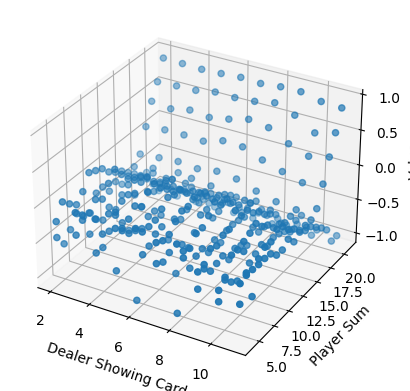

In [255]:
# Plot a 3D plot where the x-axis is the dealer showing card, the y-axis is the player sum, and the z-axis is the value
x = []
y = []
z = []
for state in OPMC.values:
    x.append(state[0][1])
    y.append(state[0][0])
    z.append(OPMC.values[state])
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
ax.set_xlabel("Dealer Showing Card")
ax.set_ylabel("Player Sum")
ax.set_zlabel("Value")
plt.show()

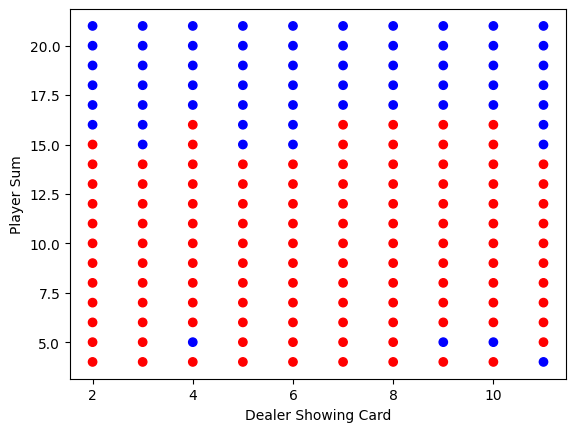

In [256]:
# 2D policy plot with the x-axis as the dealer showing card, the y-axis as the player sum, and the color as the action
x = []
y = []
z = []
for state in policy.policy:
    x.append(state[1])
    y.append(state[0])
    z.append("red" if policy.policy[state] == "HIT" else "blue")

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y, c=z)
ax.set_xlabel("Dealer Showing Card")
ax.set_ylabel("Player Sum")
plt.show()